In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [5]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_directory = '/content/drive/MyDrive/momentum-strategies/technical_indicators'

In [6]:
qqq_df = pd.read_csv(f'{file_directory}/QQQ_daily161118_211117.csv')

In [7]:
tqqq_df = pd.read_csv(f'{file_directory}/TQQQ_daily161118_211117.csv')

In [36]:
class TurtleTrading:
  def __init__(self, benchmark_df, benchmark_name):
    self.df = benchmark_df.copy()
    self.df.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
    self.benchmark_closes = benchmark_df['Close'].to_numpy()
    self.benchmark_opens = benchmark_df['Open'].to_numpy()
    self.benchmark_highs = benchmark_df['High'].to_numpy()
    self.benchmark_lows = benchmark_df['Low'].to_numpy()
    self.benchmark_name = benchmark_name
  
  def init_config(self, initial_cash=10000, dc_lengths=[20,55], atr_length=20):
    self.columns = [
      'true_range', 'atr_ema',
      'dc_high_20', 'entry_signal_20', 'dc_high_55', 'entry_signal_55',
      'dc_low_20', 'exit_signal_20', 'dc_low_55', 'exit_signal_55',
      'stop_price', 'stop_signal',
      'buy_price', 'sell_price', 'shares', 'position_size', 'cash', 
    ]
    for column in self.columns:
      setattr(self, column, np.zeros(len(self.benchmark_closes)))
    self.initial_cash = initial_cash
    for length in dc_lengths:
      self.get_dc(length)
    self.get_atr(atr_length)

  def get_dc(self, length):
    setattr(self, f'dc_high_{length}', self.df['High'].rolling(length).max().to_numpy()) #accum말고 window써야함.
    setattr(self, f'entry_signal_{length}', np.concatenate([np.array([np.nan]), getattr(self, f'dc_high_{length}')[1:] > getattr(self, f'dc_high_{length}')[:-1]]))
    setattr(self, f'dc_low_{length}', self.df['Low'].rolling(length).min().to_numpy())
    setattr(self, f'exit_signal_{length}', np.concatenate([np.array([np.nan]), getattr(self, f'dc_low_{length}')[1:] < getattr(self, f'dc_low_{length}')[:-1]]))

  def get_atr(self, length):
    prev_closes = np.roll(self.benchmark_closes, 1)
    prev_closes[0] = self.benchmark_lows[0]
    self.true_range = np.maximum.reduce([abs(self.benchmark_highs - prev_closes), abs(self.benchmark_lows - self.benchmark_highs), abs(self.benchmark_lows - prev_closes)])
    self.atr_ema = pd.Series(self.true_range).ewm(alpha=(1/20), adjust=False).mean().to_numpy()

  def set_stop_signal(self, i):
    self.limit_stop[i] = self.current_buy_price * (1 - self.limit_stop_percent)
    self.limit_stop_signal[i] = -1 if self.benchmark_closes[i] < self.limit_stop[i] else 0

  def save_to_df(self, to_csv=False):
    for column in self.columns:
      self.df[column] = getattr(self, column)
    self.df['portfolio_closes'] = self.cash + self.shares * self.benchmark_closes
    if to_csv:
      self.df.to_csv(f'{file_directory}/{current_date}_{self.benchmark_name}_turtle.csv')

In [37]:
tt = TurtleTrading(qqq_df, 'qqq')
tt.init_config()
tt.save_to_df(to_csv=True)

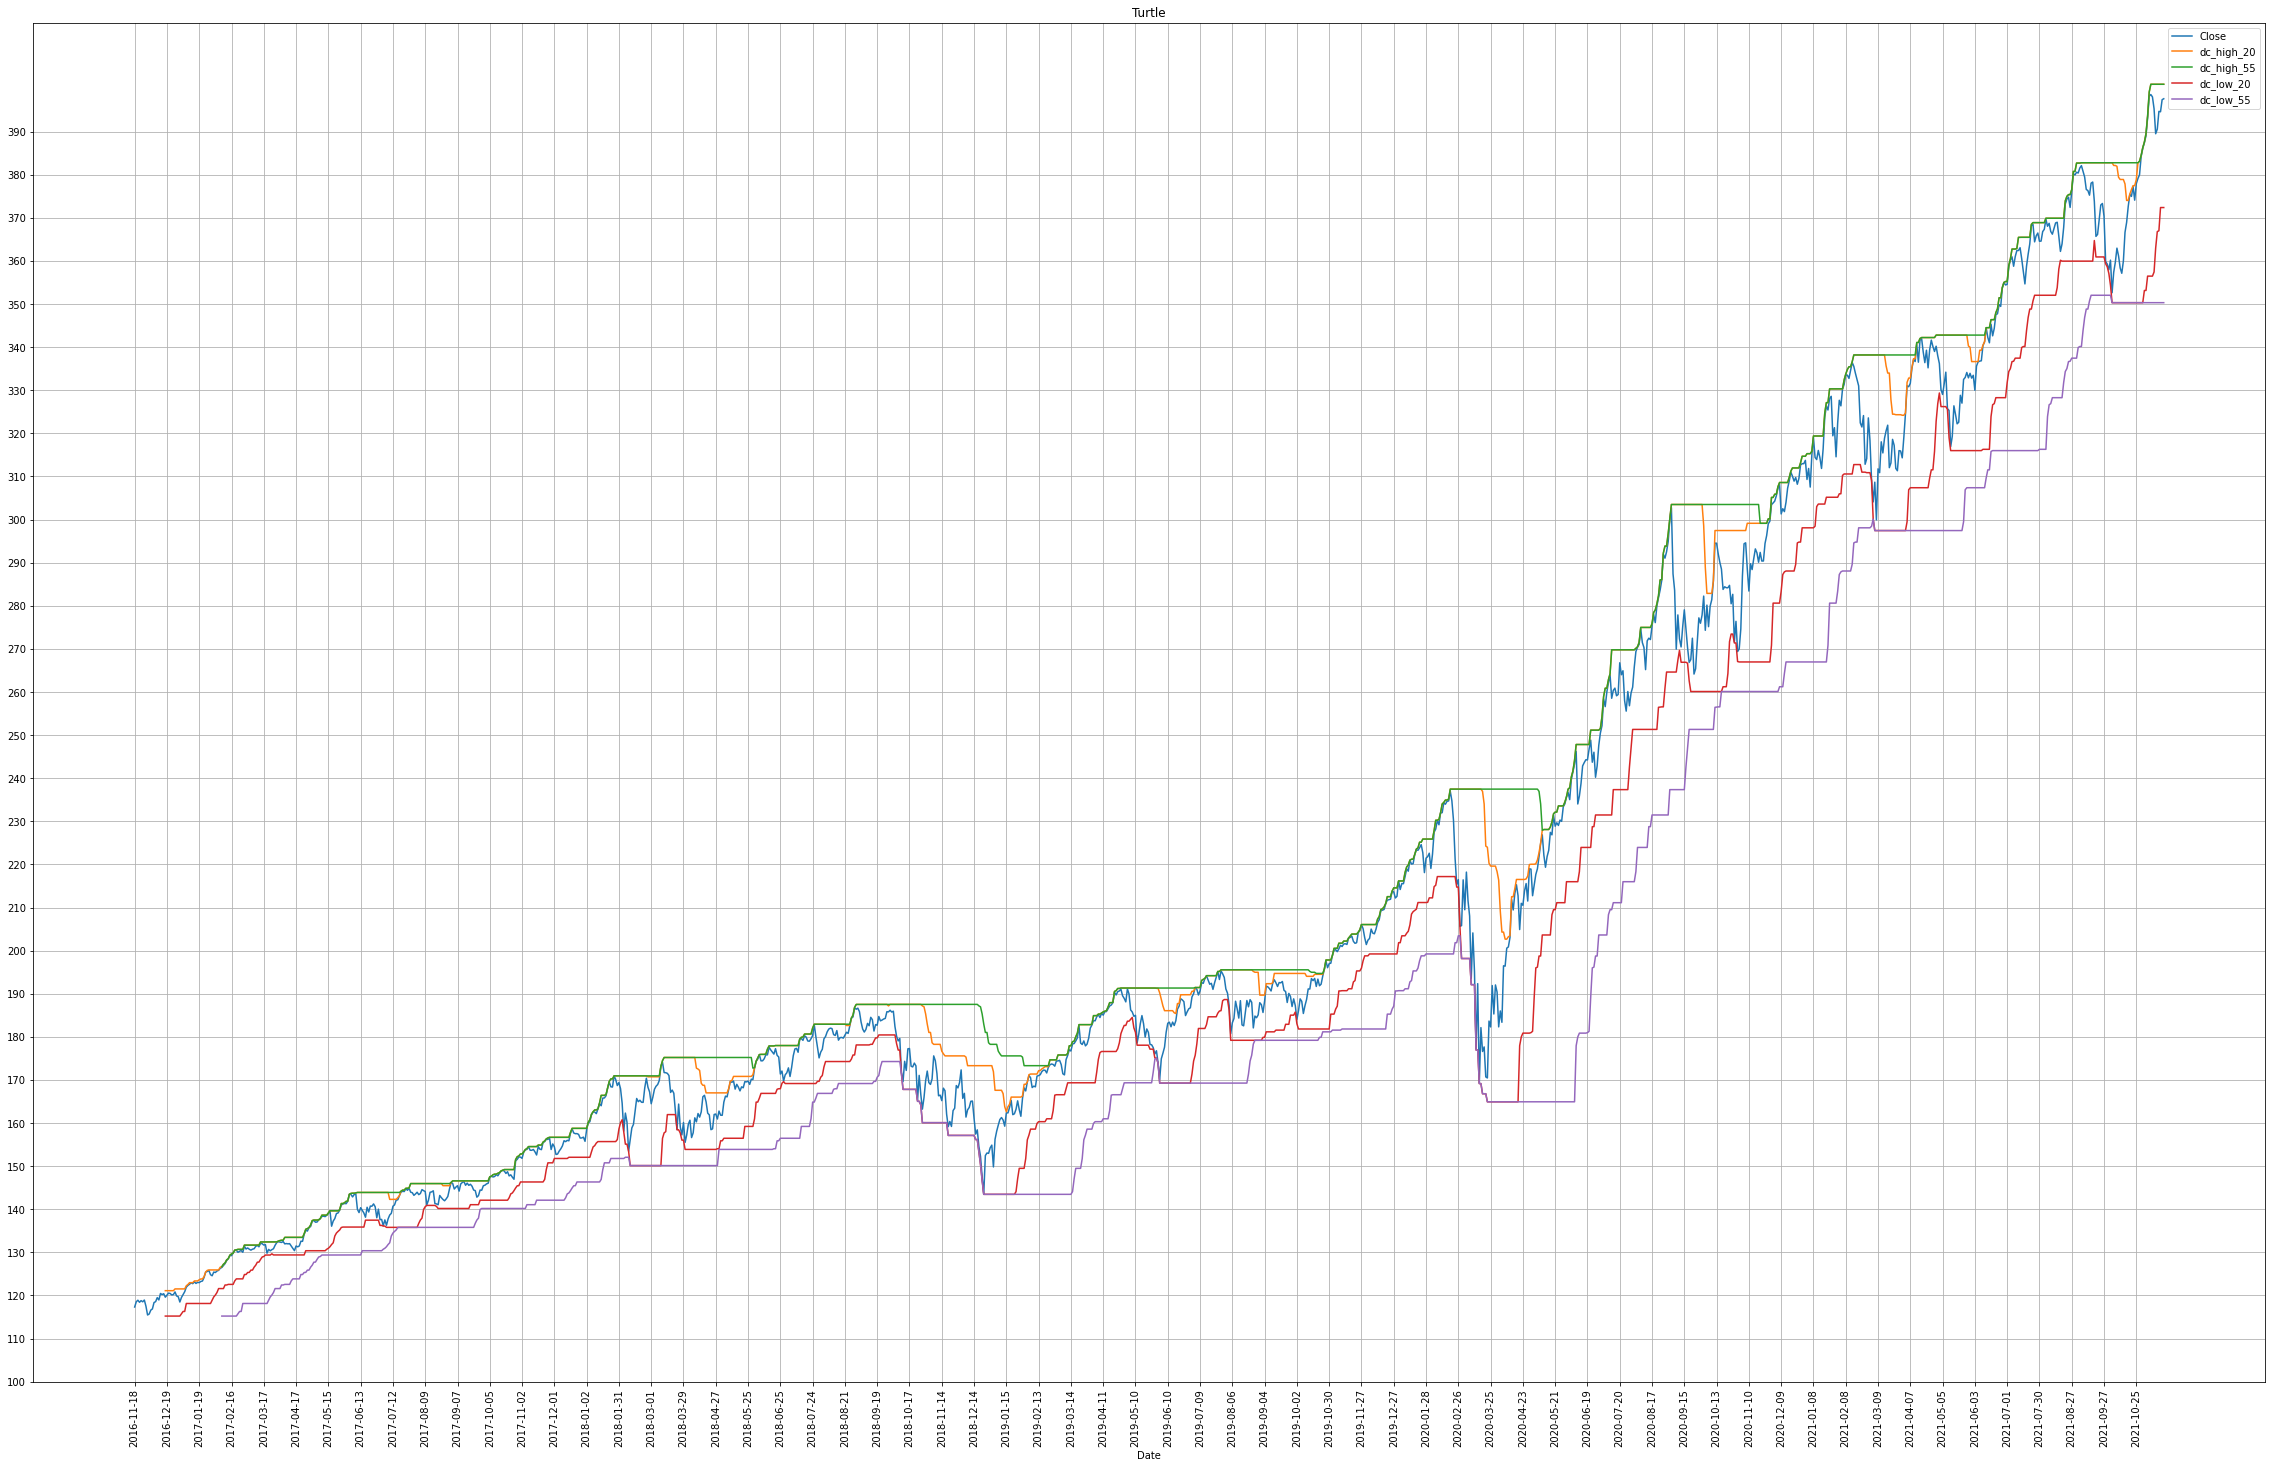

In [34]:
y_min = 100
y_max = 400
y_step = 10
chart = tt.df[['Date', 'Close', 'dc_high_20', 'dc_high_55', 'dc_low_20', 'dc_low_55']].plot(x='Date', grid=True, figsize=(40,25), xticks=np.arange(0, len(tt.df['Date']), 20), yticks=np.arange(y_min, y_max, y_step), title="Turtle")
chart.tick_params(axis='x', rotation=90)